### Model assessment
Here we compared the weights learned by several model iterations, to highlight
- Performance user parameter combinations
- Interpretation based on TF regulators
- Coherence or learned graph-weights when assisting RNA-weights, or only using ATAC-weights

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import torch
import mubind as mb
import scanpy as sc

In [4]:

# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = 'noack_2022_use_logdynamic_%i.pth' % use_logdynamic
    print(p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

noack_2022_use_logdynamic_0.pth
noack_2022_use_logdynamic_1.pth


In [5]:
ad = sc.read_h5ad('noack_2022_sample_train.h5ad')
# ad = sc.read_h5ad('atac_train.h5ad')
#rna_sample = sc.read_h5ad('rna_sample_train.h5ad')
rna_sample = ad

In [6]:
rna_sample.shape

(7468, 1999)

In [7]:
import pickle
train = pickle.load(open('train_dataloader.pkl', 'rb'))

In [8]:
%load_ext line_profiler

In [9]:
# # load the pancreas multiome dataset
# rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')


In [10]:
# %lprun -f model.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [11]:
# %lprun -f model.binding_modes.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [12]:
import matplotlib.pyplot as plt

False
True
3
order None
0 out of 288...
break


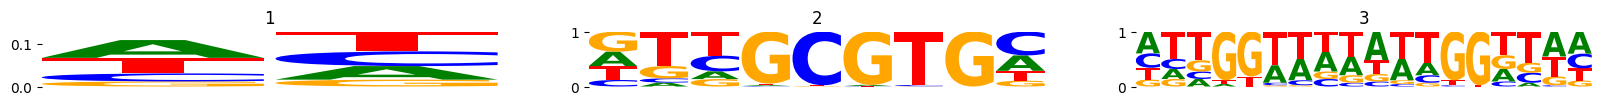

True
True
3
order None
0 out of 288...
break


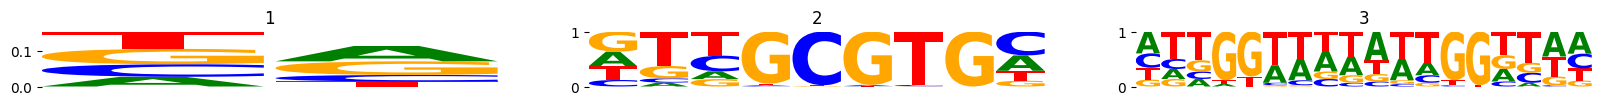

In [13]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4) #  log=True)
    plt.show()


True


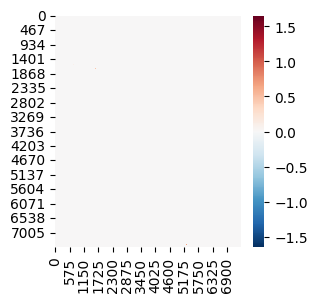

In [14]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

In [15]:
model = model_by_logdynamic[1]

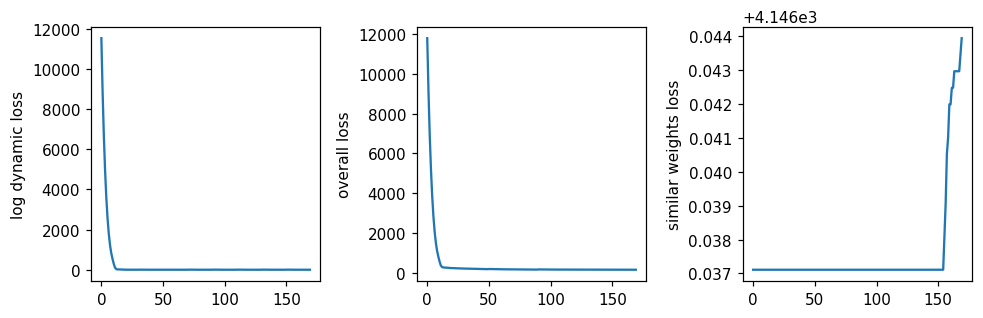

In [16]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
import numpy as np

False
True


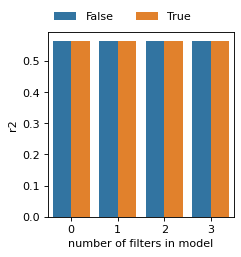

In [18]:
rcParams['figure.figsize'] = 3, 5
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams['figure.figsize'] = 3, 3
    rcParams['figure.dpi'] = 80
    ax = sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic', )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.4, 1), ncol=3, title=None, frameon=False)

    plt.xlabel('number of filters in model')
    plt.show()

In [19]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [20]:
ad.obs['dynamic_score'].describe()

count    7468.000000
mean        0.428661
std         0.048458
min         0.000000
25%         0.428606
50%         0.428661
75%         0.428717
max         1.000000
Name: dynamic_score, dtype: float64

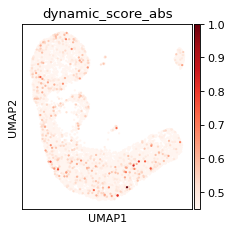

In [21]:
ad.obs['dynamic_score_abs'] = ad.obs['dynamic_score'].abs()
sc.pl.umap(ad, color='dynamic_score_abs', color_map='Reds', vmin=.45)

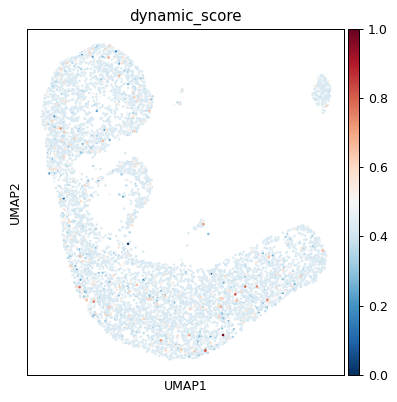

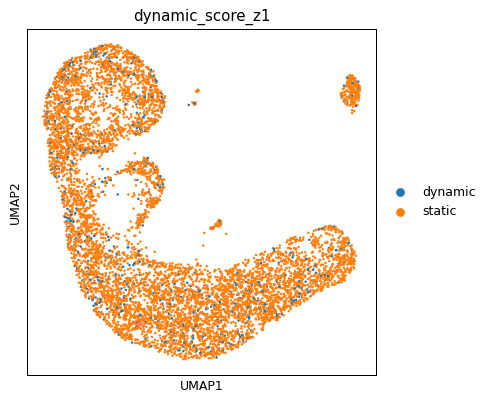

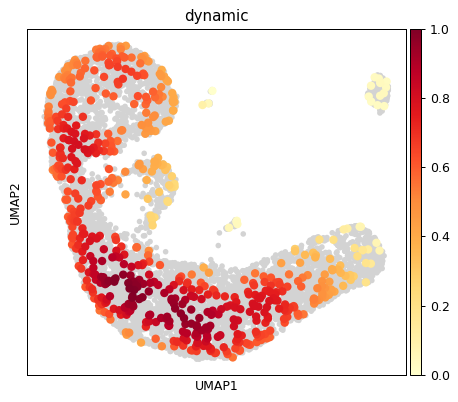

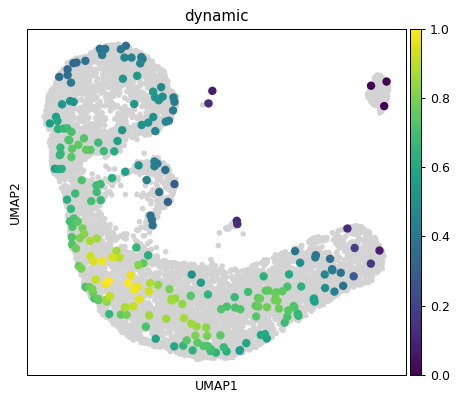

In [22]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic', color_map='viridis') # basis='umap', groupby='dynamic_score_cluster')

<Axes: >

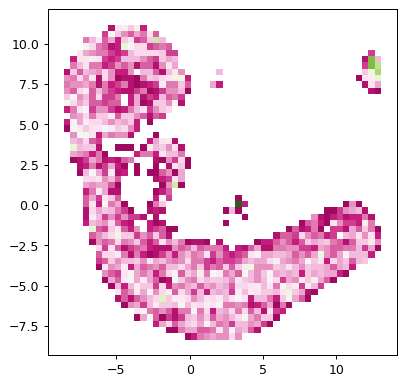

In [23]:
import seaborn as sns
umap = ad.obsm['X_umap']
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap='PiYG')

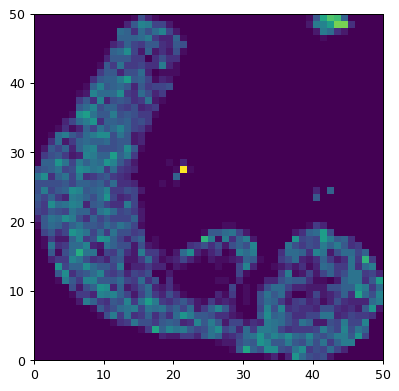

In [24]:
plt.pcolormesh(
    np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0]
)

In [25]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [26]:
x = umap[:,1] # array_txt[:,0]
y = umap[:,1] # array_txt[:,1]
z = ad.obs['dynamic_score'].values # array_txt[:,2]


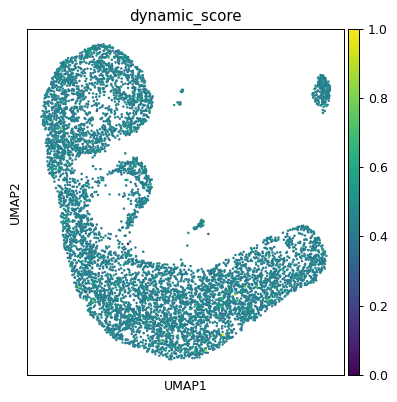

In [27]:
sc.pl.umap(ad, color='dynamic_score')

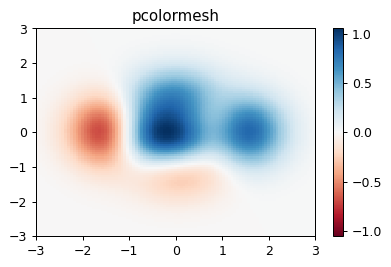

In [28]:
import matplotlib.pyplot as plt
import numpy as np
rcParams['figure.figsize'] = 5, 3

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [29]:
import itertools
import numpy as np

def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)


In [30]:
cell_type_key = 'clusters'

In [31]:
grid_dyn_score = grid(umap[:,0], umap[:,1], ad.obs['dynamic_score'], size_x=1, size_y=1)
grid_counts = grid(umap[:,0], umap[:,1], ad.obs[cell_type_key].cat.codes.values, size_x=1, size_y=1)

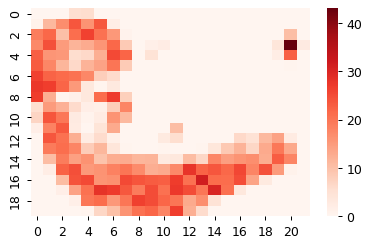

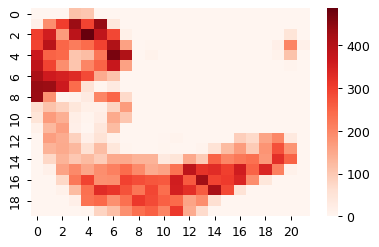

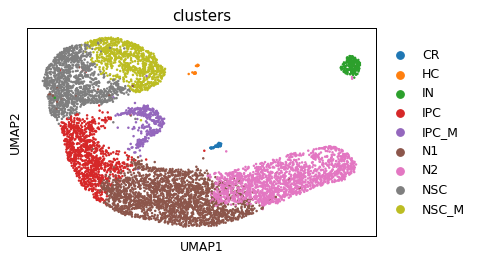

In [32]:

sns.heatmap(grid_dyn_score, cmap='Reds')
plt.show()
sns.heatmap(grid_counts, cmap='Reds')
plt.show()

sc.pl.umap(ad, color=cell_type_key)

In [33]:
# for optimize_log_dynamic in model_by_logdynamic:
#     mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
#     print(optimize_log_dynamic)
#     model = model_by_logdynamic[optimize_log_dynamic]
#     mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
#     plt.show()

#     mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
#     mb.pl.logo(model,
#                title=False,
#                xticks=False,
#                rowspan_dinuc=0,
#                rowspan_mono=1,
#                n_rows=12,
#                n_cols=3,
#                stop_at=20) # n_cols=len(reduced_groups))
#     plt.show()


In [34]:
model = model_by_logdynamic[True]

In [35]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense() # (C, C)

In [36]:
# number of non_zero weights
len(G[G != 0])

144504

In [37]:
# output = model(**inputs, use_conn=False, return_binding_scores=True)

In [38]:
print('here...')

here...


In [39]:
ad

AnnData object with n_obs × n_vars = 7468 × 1999
    obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'louvain', 'clusters', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'tss_start', 'tss_end', 'k', 'acc_score', 'acc_score_rank', 'chr', 'summit.start', 'summit.end', 'k.summit'
    uns: 'clusters_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'recover_d

In [40]:
model = model.cuda()

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
# device

In [42]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [43]:
train

In [44]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic].cuda()

    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'

        
        output = model(**inputs, use_conn=False, return_binding_scores=True)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T


    # ad.layers['velocity'] = pred
    
    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()
    
    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']
    
    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)


X = ad.X.A
G @ binding_scores
np.random.shuffle(binding_scores)

False
True
here...
(512, 7468)
13439817000000.0
here...
(512, 7468)
13954931000000.0
here...
(512, 7468)
23256824000000.0
here...
(463, 7468)
17114155000000.0


In [45]:
import scvelo as scv

In [46]:
ad
ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [47]:
np.random.shuffle(binding_scores)
binding_scores

array([[3464655.2, 3560957.5, 3588096. , ..., 4903223.5, 5130040. ,
        4402886. ],
       [3464810.8, 3561230.8, 3588259.5, ..., 4903853. , 5130842. ,
        4403355. ],
       [3464937.2, 3561306. , 3588388.5, ..., 4904163. , 5131107. ,
        4403666. ],
       ...,
       [3463847. , 3560365.5, 3587209.2, ..., 4900899.5, 5127860. ,
        4400773. ],
       [3464190. , 3560610. , 3587578.2, ..., 4901989. , 5128898.5,
        4401798. ],
       [3464100.2, 3560610.5, 3587488.5, ..., 4901669.5, 5128602.5,
        4401468.5]], dtype=float32)

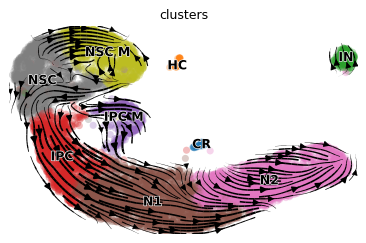

In [48]:
try:
    scv.pl.velocity_embedding_stream(rna_sample, color=cell_type_key)
except Exception:
    print("sample too small.")

In [49]:
# np.random.shuffle(binding_scores)
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

<Axes: >

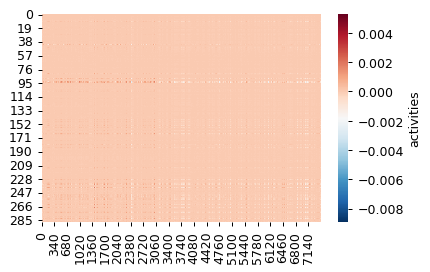

In [50]:
import seaborn as sns
act = model.get_log_activities().detach().cpu().squeeze(0)
sns.heatmap(act, cmap='RdBu_r', cbar_kws={'label': 'activities'})

In [51]:
rna_sample.layers['velocity'].shape, rna_sample.shape

((7468, 1999), (7468, 1999))

In [52]:
# scv.pl.velocity_graph(rna_sample)

In [53]:

# ax = scv.pl.velocity_embedding_stream(ad,
#                                       color='celltype',
#                                       # density=2,
#                                       arrow_color='black',
#                                       n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [54]:
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [55]:
# scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

## Study the asssociations betweeen obtained weights and cluster-specific transcription factors

Load information from archetypes DB (Vierstra et al 2020)

In [56]:
rna_sample, ad.shape

(AnnData object with n_obs × n_vars = 7468 × 1999
     obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'louvain', 'clusters', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'tss_start', 'tss_end', 'k', 'acc_score', 'acc_score_rank', 'chr', 'summit.start', 'summit.end', 'k.summit'
     uns: 'clusters_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'recov

In [57]:
rna_sel = rna_sample # rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape

(7468, 1999)

In [58]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [59]:
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'

anno = mb.datasets.archetypes_anno()

In [60]:
rna_sel.shape
anno.sort_values('Cluster_ID')

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
61,1,HD/1,homeodomain,LHX6_homeodomain_3,12,0,12,2
72,2,HD/2,homeodomain,ALX3_MA0634.1,26,8,16,186
79,3,HD/3,homeodomain,VENTX_homeodomain_2,21,3,20,1
80,4,HD/4,homeodomain,BARX1_MOUSE.H11MO.0.C,17,5,13,17
81,5,HD/5,homeodomain,BARX1_homeodomain_1,21,2,18,6
...,...,...,...,...,...,...,...,...
163,282,PAX/2,PAX,PAX5_HUMAN.H11MO.0.A,24,4,21,3
161,283,PAX-halfsite,PAX,Pax2_MA0067.1,8,1,7,1
0,284,AHR,bHLH,AHR_HUMAN.H11MO.0.B,9,2,8,3
105,285,KLF/SP/3,C2H2,KLF8_HUMAN.H11MO.0.C,9,0,9,2


False


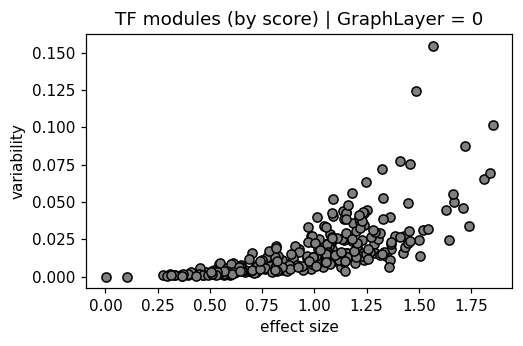

True


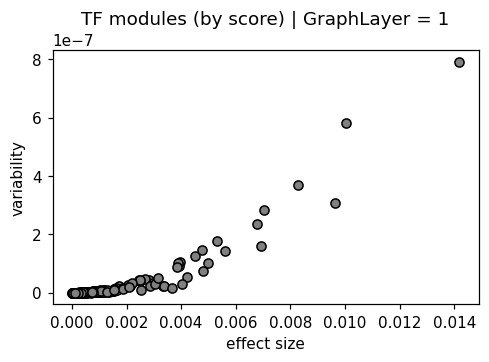

In [61]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 110})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var, color='gray', edgecolors='black')
    plt.xlabel('effect size')
    plt.ylabel('variability')
    plt.title('TF modules (by score) | GraphLayer = %i' % optimize_log_dynamic )
    plt.show()

In [62]:
# unique names for annotation
names = anno['Name'] # .sort_values('Name')
added = dict()
new_name = []
for name in names:
    if not name in added:
        new_name.append(name)
        added[name] = 0
    else:
        new_name.append(name + '_%i' % added[name])
        added[name] += 1
anno['Name_unique'] = new_name


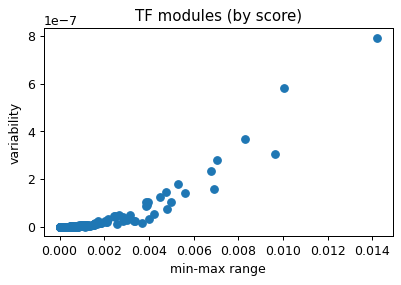

In [63]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        # print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])



In [64]:

# add archetypes name
meta = pd.DataFrame(pd.concat([delta, var], axis=1))
meta.columns = ['max_effect', 'variability']
meta['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
meta['archetypes_name'] = meta['name'].map(anno.set_index('Cluster_ID')['Name_unique'])
meta['archetypes_name'] = np.where(pd.isnull(meta['archetypes_name']), meta['name'], meta['archetypes_name'])

meta['archetypes_seed'] = meta['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])
meta = meta.sort_values('max_effect', ascending=0)
meta

res = res.merge(meta, left_on='archetype_id', right_on='name')
res = res.sort_values('p_val', ascending=True)

In [65]:
name_by_filter_id = meta['archetypes_name'].to_dict()
# name_by_filter_id

## Observe general scores per case

<Axes: xlabel='max_effect', ylabel='archetypes_name'>

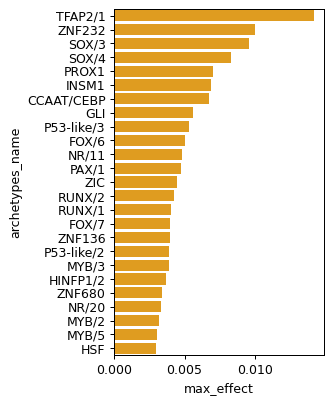

In [66]:
rcParams['figure.figsize'] =3, 5
sns.barplot(data=res.sort_values('max_effect', ascending=False).head(25), x='max_effect', y='archetypes_name', color='orange')

In [67]:
res

,opt_log_dynamic,archetype_id,spearman,p_val,max_effect,variability,name,archetypes_name,archetypes_seed
98,True,97,-0.071164,7.431876e-10,0.000172,7.701737e-11,97,MECP2,MECP2_HUMAN.H11MO.0.C
13,True,12,-0.068299,3.460593e-09,0.000031,2.615277e-12,12,HD/12,PBX1_HUMAN.H11MO.0.A
73,True,72,-0.062680,5.924905e-08,0.000189,1.251012e-10,72,TBX/3,EOMES_TBX_2
196,True,195,-0.061456,1.066588e-07,0.000480,1.149490e-09,195,HOMEZ,HOMEZ_HOMEZ_1
197,True,196,-0.060027,2.089312e-07,0.000623,1.545207e-09,196,IRF/4,IRF7_IRF_2
...,...,...,...,...,...,...,...,...,...
287,True,286,-0.000418,9.711844e-01,0.000740,3.814564e-09,286,ZSCAN4,ZSCAN4_C2H2_1
184,True,183,-0.000272,9.812482e-01,0.002501,4.323569e-08,183,MEF2,MEF2A_HUMAN.H11MO.0.A
34,True,33,0.000236,9.837570e-01,0.000245,4.773562e-10,33,NR/4,RXRA_nuclearreceptor_2
29,True,28,-0.000178,9.877292e-01,0.000176,1.510504e-10,28,HD/22,NKX2-3_MA0672.1


True
1
order None
0 out of 288...
10 out of 288...
break


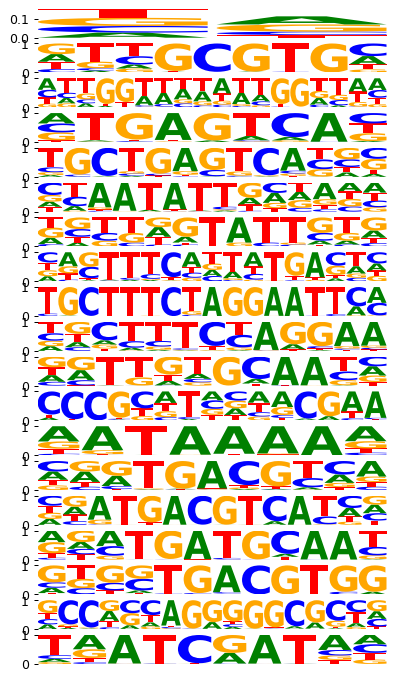

In [68]:
# visualize the logos as obtained by the model in each step
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

True
1
order Index([ 98,  13,  73, 196, 197,  63, 219,  81, 109, 103,  41,  97,  59,  21,
       126,   8,  85,  87, 277,  70],
      dtype='int64')
0 out of 288...
10 out of 288...


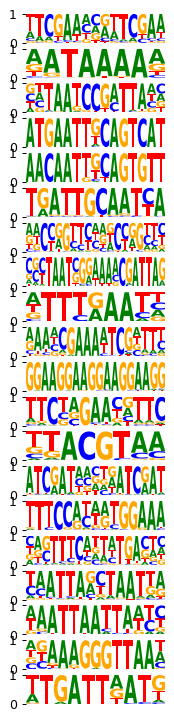

<Figure size 180x1800 with 0 Axes>

In [69]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [70]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 7.148228


In [71]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [72]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [73]:
def find_varname(ad, k):
    return ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]

In [74]:
from scipy.stats import spearmanr, pearsonr

Calculate global correlations between the activities obtained per motif and gene-specific expression

In [75]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')


False
True


In [76]:

def get_act_gene_corr(model_by_logdynamic, shuffle=False, random_state=0):
    print('association between motif activities and related TF targets ')
    res = []
    print(len(all_targets))

    rna_sel_df = rna_sel.to_df()

    for optimize_log_dynamic in model_by_logdynamic:
        print('use GraphLayer = %i' % optimize_log_dynamic)
        model = model_by_logdynamic[optimize_log_dynamic]

        log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
        log_act = pd.DataFrame(log_act.detach().cpu().numpy())
        log_act.index = ad.obs_names

        ad.obsm['log_activities'] = log_act
        ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

        for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
            next_log_act = ad.obsm['log_activities'][k].values

            if shuffle:
                np.random.seed(random_state)
                np.random.shuffle(next_log_act)
            # print(ki)
            # if ki % 30 == 0:
            #     print(ki)
            names = set()
            clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
            for g in clu_sel:
                names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
            for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
                names.add(g.split('_')[0].split('.')[0])
            # print(k, names)
            next_targets = set()
            for name in names:
                target = find_varname(rna_sel, name)
                # print(name, target)
                for t in target:
                    next_targets.add(t)

            # for t in all_targets:
            for t in set(all_targets).intersection(next_targets):
                gex = rna_sel_df[[t]].to_numpy() # rna_sel_df[t].A
                assert gex.shape[1] == 1
                gex = gex.flatten()
                # print(next_log_act.shape, gex.shape)
                # print(t, pearsonr(next_log_act, gex))
                res.append([ki, optimize_log_dynamic, k, t, t in next_targets] +
                        list(spearmanr(next_log_act, gex)))
                
    res = pd.DataFrame(res, columns=['filter_id', 'opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

    # p-values
    res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
    res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])
    
    # p-val adjust
    from statsmodels.stats.multitest import fdrcorrection
    res['p_adj'] = fdrcorrection(res['p_val'])[1]
    return res


In [77]:
res = get_act_gene_corr(model_by_logdynamic)
shuffled = [get_act_gene_corr(model_by_logdynamic, shuffle=1, random_state=i) for i in range(3)]

association between motif activities and related TF targets 
591
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets 
591
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets 
591
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets 
591
use GraphLayer = 0
use GraphLayer = 1


In [78]:
n_pos = res[res['p_adj'] < 0.1].shape[0]
n_pos
n_neg = [s[s['p_adj'] < 0.1].shape[0] for s in shuffled]
n_neg

[0, 0, 0]

In [79]:
shuffled[0].sort_values('p_val')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
601,108,False,109,Dusp14,True,-0.041237,0.000365,KLF/SP/2,0.532254
979,69,True,70,Vtn,True,-0.034185,0.003131,TBX/1,0.978781
794,48,True,49,Atf3,True,-0.034019,0.003280,CREB/ATF/1,0.978781
636,165,False,166,Tead2,True,-0.033152,0.004167,TEAD,0.978781
1069,69,True,70,Tgfb2,True,0.031873,0.005876,TBX/1,0.978781
...,...,...,...,...,...,...,...,...,...
154,69,False,70,Hs3st4,True,-0.000088,0.993965,TBX/1,0.995894
40,31,False,32,Acot1,True,0.000082,0.994359,NR/3,0.995894
1450,256,True,257,Trp73,True,-0.000079,0.994530,P53-like/1,0.995894
844,68,True,69,Meis2,True,0.000043,0.997011,MIES,0.997694


In [80]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
729,280,False,281,Pax6,True,-0.590654,0.000000,PAX/1,0.000000
577,95,False,96,Celf2,True,-0.606624,0.000000,ETS/2,0.000000
404,69,False,70,Ect2,True,0.502894,0.000000,TBX/1,0.000000
575,95,False,96,Celf3,True,-0.575801,0.000000,ETS/2,0.000000
242,69,False,70,Scrt2,True,-0.437462,0.000000,TBX/1,0.000000
...,...,...,...,...,...,...,...,...,...
256,69,False,70,Rftn1,True,0.000543,0.962563,TBX/1,0.965208
281,69,False,70,Lrrtm3,True,-0.000423,0.970845,TBX/1,0.972844
89,57,False,58,Mitf,True,0.000338,0.976676,Ebox/CACGTG/1,0.978016
1099,69,True,70,Ptprm,True,0.000328,0.977408,TBX/1,0.978078


In [81]:
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
# res[res['p_adj'] < 0.1]

In [82]:
genes_by_module_name = res.groupby(['module_name'])['gene_name'].apply(lambda grp: list(grp.value_counts().index)).to_dict()
# genes_by_module_name

In [83]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
729,280,False,281,Pax6,True,-0.590654,0.000000,PAX/1,0.000000
577,95,False,96,Celf2,True,-0.606624,0.000000,ETS/2,0.000000
404,69,False,70,Ect2,True,0.502894,0.000000,TBX/1,0.000000
575,95,False,96,Celf3,True,-0.575801,0.000000,ETS/2,0.000000
242,69,False,70,Scrt2,True,-0.437462,0.000000,TBX/1,0.000000
...,...,...,...,...,...,...,...,...,...
256,69,False,70,Rftn1,True,0.000543,0.962563,TBX/1,0.965208
281,69,False,70,Lrrtm3,True,-0.000423,0.970845,TBX/1,0.972844
89,57,False,58,Mitf,True,0.000338,0.976676,Ebox/CACGTG/1,0.978016
1099,69,True,70,Ptprm,True,0.000328,0.977408,TBX/1,0.978078


In [84]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot(index='k', columns='opt_log_dynamic', values='spearman')
# df2 = res # .pivot(index='k', columns='opt_log_dynamic', values='spearman')

In [85]:
df2

opt_log_dynamic,False,True
k,,
Abat_70,-0.096748,-0.045127
Abracl_70,-0.339767,-0.288599
Acot1_32,0.020966,0.024638
Acot1_41,0.410360,0.134649
Acot1_70,0.326861,0.181711
...,...,...
Zfp536_257,0.182234,0.213374
Zic1_110,0.001593,-0.001791
Zic1_273,-0.070301,0.010298


In [86]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
# df2 = df2.sort_values('matched', ascending=True)
# plt.scatter(df2[True], df2[True],
#             color=np.where(df2['matched'], 'blue', 'gray'),
#             s=np.where(df2['matched'], 30, 5))
# plt.xlabel('TF activity (graph = off)')
# plt.ylabel('TF activity (graph = on)')
# plt.axhline(0, color='gray', ls='--', zorder=0)
# plt.axvline(0, color='gray', ls='--', zorder=0)


In [87]:
# df2[df2['matched'] == True].sort_values(True, ascending=False)

In [88]:
# res['arch_name'] = name_by_filter_id

In [89]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
729,280,False,281,Pax6,True,-0.590654,0.000000,PAX/1,0.000000,Pax6_281
577,95,False,96,Celf2,True,-0.606624,0.000000,ETS/2,0.000000,Celf2_96
404,69,False,70,Ect2,True,0.502894,0.000000,TBX/1,0.000000,Ect2_70
575,95,False,96,Celf3,True,-0.575801,0.000000,ETS/2,0.000000,Celf3_96
242,69,False,70,Scrt2,True,-0.437462,0.000000,TBX/1,0.000000,Scrt2_70
...,...,...,...,...,...,...,...,...,...,...
256,69,False,70,Rftn1,True,0.000543,0.962563,TBX/1,0.965208,Rftn1_70
281,69,False,70,Lrrtm3,True,-0.000423,0.970845,TBX/1,0.972844,Lrrtm3_70
89,57,False,58,Mitf,True,0.000338,0.976676,Ebox/CACGTG/1,0.978016,Mitf_58
1099,69,True,70,Ptprm,True,0.000328,0.977408,TBX/1,0.978078,Ptprm_70


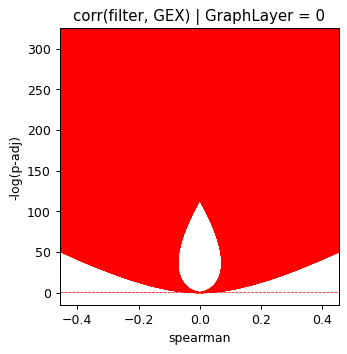

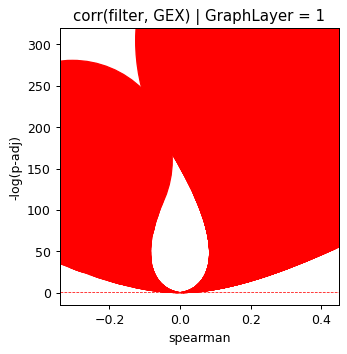

In [90]:
rcParams['figure.figsize'] = 4, 4
rcParams['figure.dpi'] = 90

for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 2), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('corr(filter, GEX) | GraphLayer = %i' % optimize_log_dynamic)
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

<Axes: xlabel='spearman', ylabel='Count'>

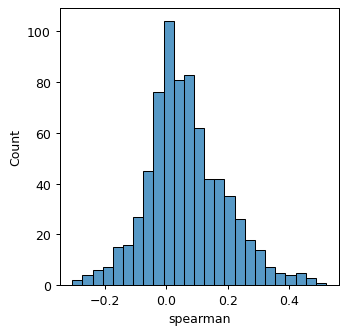

In [91]:
sns.histplot(grp['spearman'])

In [92]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

Text(0, 0.5, '# associations')

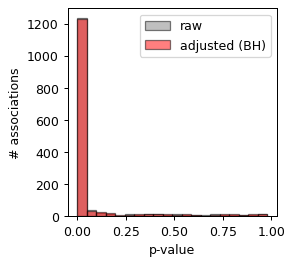

In [93]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 90
plt.hist(res['p_val'], color='gray', bins=20, label='raw', alpha=.5, edgecolor = 'black')
plt.hist(res['p_adj'], color='red', bins=20, label='adjusted (BH)', alpha=.5, edgecolor = 'black')
plt.xlabel('p-value')
plt.legend()
plt.ylabel('# associations')

In [94]:
res[res['p_adj'] < 0.05]

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
1,1,False,2,Lhx6,True,-0.129152,3.807956e-29,HD/2,8.967121e-29,Lhx6_2
2,1,False,2,Dlx6os1,True,-0.139005,1.538711e-33,HD/2,3.820609e-33,Dlx6os1_2
3,1,False,2,Draxin,True,-0.133662,4.078170e-31,HD/2,9.792975e-31,Draxin_2
4,1,False,2,Dlx1as,True,-0.092798,9.327726e-16,HD/2,1.717337e-15,Dlx1as_2
5,1,False,2,Emx2,True,0.225997,4.141738e-87,HD/2,1.956938e-86,Emx2_2
...,...,...,...,...,...,...,...,...,...,...
1451,256,True,257,Zfp536,True,0.213374,1.231093e-77,P53-like/1,5.302054e-77,Zfp536_257
1453,261,True,262,Gli3,True,0.116705,4.583153e-24,GLI,9.898525e-24,Gli3_262
1454,262,True,263,Tfap2c,True,0.307902,9.947546e-164,TFAP2/2,9.430790e-163,Tfap2c_263
1456,272,True,273,Zic2,True,0.057283,7.290372e-07,ZIC,1.069743e-06,Zic2_273


In [95]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

In [96]:
log_act = ad.obsm['log_activities'].copy()

In [97]:
cols_act = ['intercept', 'dinuc_bias'] + [name_by_filter_id[k] for k in log_act.columns[2:]]
log_act.columns = cols_act

In [98]:
import anndata
ad_act = anndata.AnnData(log_act)
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

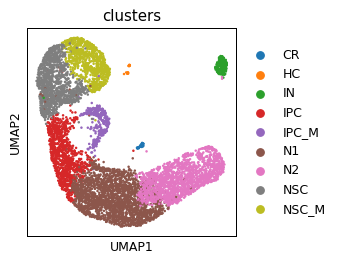

In [99]:
sc.pl.umap(ad_act, color=cell_type_key)


Rank genes groups using the annotation

In [100]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)
rkg_df = []
for ct in ad_act.obs[cell_type_key].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2[cell_type_key] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

NSC_M
N1
IPC
NSC
IPC_M
N2
CR
HC
IN


,names,scores,logfoldchanges,pvals,pvals_adj,clusters,module_name
0,intercept,33.418285,3.002532,2.983272e-170,8.591824e-168,NSC_M,intercept
1,LEF1,2.238598,NaN,2.535930e-02,9.991206e-01,NSC_M,LEF1
2,PAX/2,2.062801,NaN,3.933620e-02,9.991206e-01,NSC_M,PAX/2
3,ZNF784,2.031709,NaN,4.240202e-02,9.991206e-01,NSC_M,ZNF784
4,HD/24,1.902095,NaN,5.737683e-02,9.991206e-01,NSC_M,HD/24


Get top modules

In [101]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

In [102]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)

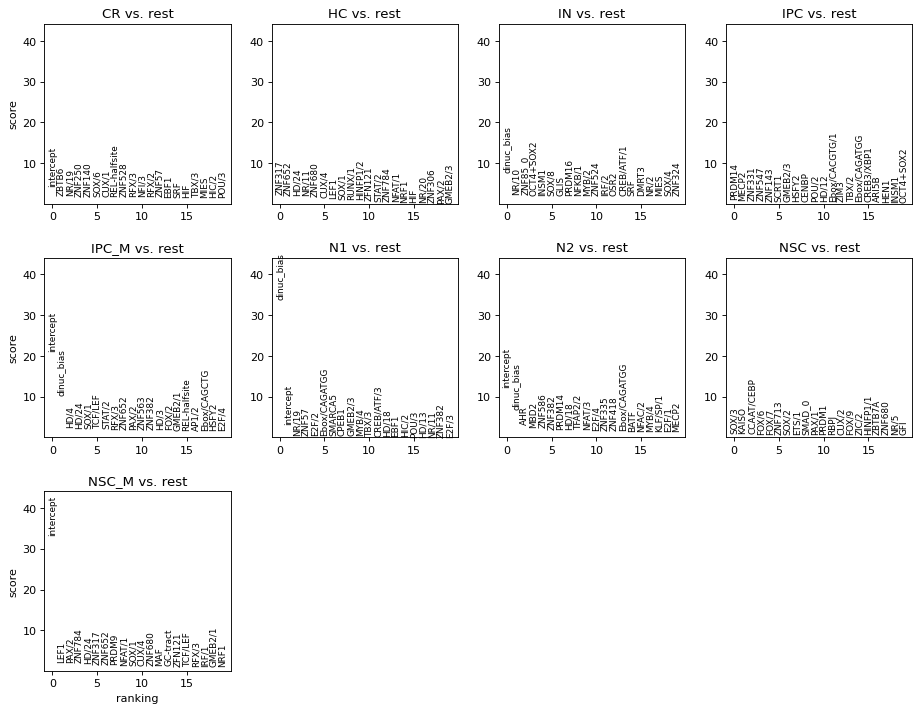

In [103]:
rcParams['figure.figsize'] = 3.5, 3.5
rcParams['figure.dpi'] = 80
sc.pl.rank_genes_groups(ad_act)


In [104]:
set(res[(res['p_adj'] < 1e-5)]['k'])

{'Abat_70',
 'Abracl_70',
 'Acot1_41',
 'Acot1_70',
 'Acot7_70',
 'Actb_70',
 'Actl6b_70',
 'Actn1_70',
 'Actr3b_70',
 'Adamts18_70',
 'Adamts1_70',
 'Adamts5_70',
 'Amotl2_70',
 'Arfgef3_248',
 'Arg2_248',
 'Arhgap11a_248',
 'Arhgap20_248',
 'Arhgap21_248',
 'Arhgap31_248',
 'Arhgap33_248',
 'Arhgef25_248',
 'Arhgef28_248',
 'Arhgef2_248',
 'Arid5b_248',
 'Arl4d_248',
 'Arl6ip1_248',
 'Arl6ip5_248',
 'Arl8a_248',
 'Arnt2_248',
 'Arnt2_58',
 'Arnt2_70',
 'Arpc1b_248',
 'Arpp21_248',
 'Arrdc3_248',
 'Arsb_248',
 'Arx_2',
 'Arx_248',
 'Arx_8',
 'Atad2_70',
 'Atad5_70',
 'Atcay_70',
 'Atf3_49',
 'Atf3_54',
 'Atf3_70',
 'Atl1_70',
 'Atp1a1_70',
 'Atp1a2_70',
 'Atp1a3_70',
 'Atp1b1_70',
 'Atp2b1_70',
 'Atp2b2_70',
 'Atp9a_70',
 'Atxn1_70',
 'Atxn7_70',
 'B3galt1_70',
 'B3galt2_70',
 'B3gat2_70',
 'B3glct_70',
 'Bach2_53',
 'Basp1_109',
 'Basp1_112',
 'Bcar1_248',
 'Btbd17_70',
 'Btg1_70',
 'Btg2_70',
 'C1qtnf4_70',
 'CT025619.1_70',
 'Car14_248',
 'Card19_248',
 'Carhsp1_112',
 'Carhsp1_248

In [105]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
7,1,False,2,Fen1,True,0.331415,6.548163e-191,HD/2,7.772617e-190,Fen1_2
21,7,False,8,Arx,True,0.321283,6.757006e-179,HD/8,7.417465e-178,Arx_8
32,24,False,25,Otx1,True,0.287582,3.585459e-142,HD/19,2.860530e-141,Otx1_25
737,1,True,2,Fen1,True,0.275083,9.042811e-130,HD/2,6.347358e-129,Fen1_2
16,1,False,2,Tsen15,True,0.251086,9.819281e-108,HD/2,5.780706e-107,Tsen15_2
750,6,True,7,Fen1,True,0.238823,2.377576e-97,HD/7,1.280908e-96,Fen1_7
5,1,False,2,Emx2,True,0.225997,4.141738e-87,HD/2,1.956938e-86,Emx2_2
6,1,False,2,Arx,True,0.169757,2.127617e-49,HD/2,6.595160e-49,Arx_2
746,1,True,2,Tsen15,True,0.159801,6.635756e-44,HD/2,1.903380e-43,Tsen15_2
18,6,False,7,Emx1,True,-0.144241,5.218820e-36,HD/7,1.348580e-35,Emx1_7


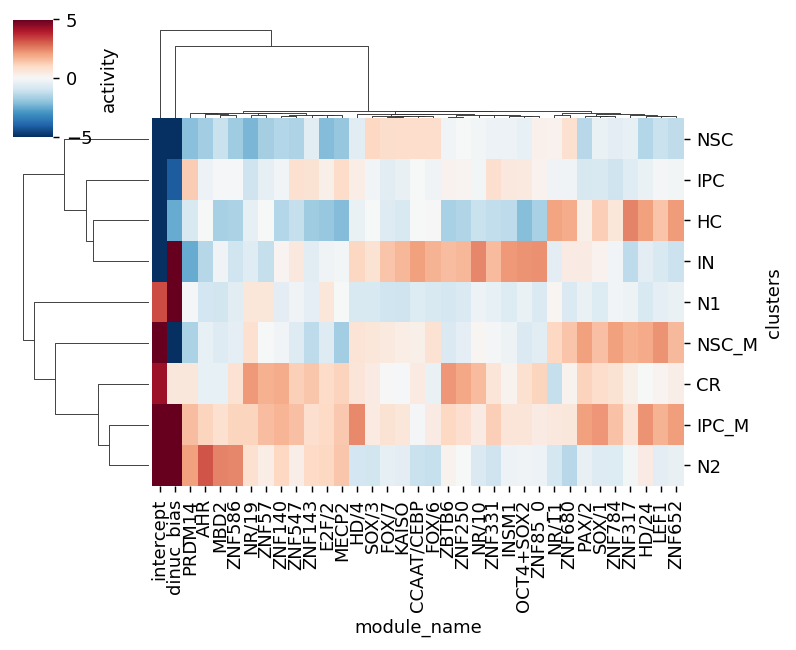

In [106]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby(cell_type_key).head(5)['module_name'])
best = rkg_df[rkg_df['module_name'].isin(mod_names_best)]
rcParams['figure.dpi'] = 130
sns.clustermap(best.pivot(index=cell_type_key, columns='module_name', values='scores'),
               cbar_kws={'label': 'activity'}, cmap='RdBu_r',
               vmin=-5, vmax=5,
               figsize=[6.2, 5],
               # dpi=100,
               xticklabels=True)


In [107]:
rna_tfs = rna_sel.to_df()[list(set(res['gene_name']))]
rna_tfs[cell_type_key] = rna_sel.obs[cell_type_key]
mean_tfs = rna_tfs.groupby(cell_type_key).mean()

act_tfs_df = ad_act.to_df()
act_tfs_df[cell_type_key] = ad_act.obs[cell_type_key]
mean_act_tf = act_tfs_df.groupby(cell_type_key).mean()

In [108]:
corr_celltype = []
for i, c1 in enumerate(mean_act_tf):
    if i % 50 == 0:
        print(i, mean_act_tf.shape[1])
    for j, c2 in enumerate(mean_tfs):
        if not c1 in genes_by_module_name or not c2 in genes_by_module_name[c1]:
            continue
        a = mean_act_tf[c1]
        b = mean_tfs[c2]
        corr_celltype.append([c1, c2, mean_act_tf.index[np.argmax(mean_act_tf[c1])]] + list(pearsonr(a, b)))

corr = pd.DataFrame(corr_celltype,
                    columns=['module_name', 'gene_name', 'cell_type', 'pearsonr', 'p_val'])
corr = corr.sort_values('pearsonr', ascending=False)


0 288
50 288
100 288
150 288
200 288
250 288


In [109]:
# sc.pl.dotplot(rna_sel, groupby='celltype', var_names=list(set(res['gene_name'])))

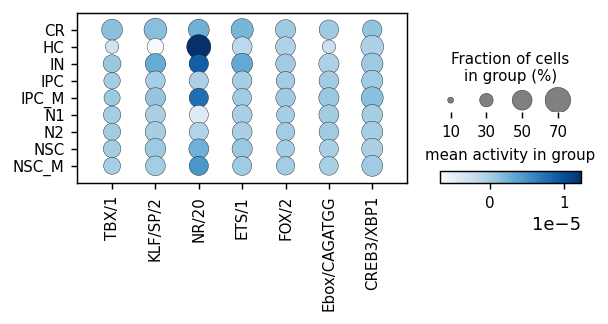

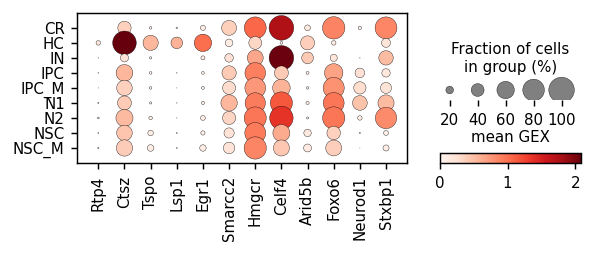

In [110]:
module_names = corr.sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr.sort_values('p_val').groupby('cell_type').head(3)['gene_name']

sc.pl.dotplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[5, 1.7],
            colorbar_title='mean activity in group')
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.5])

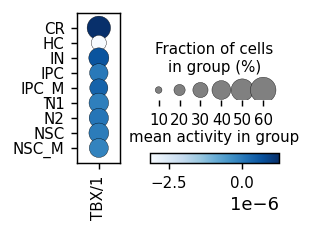

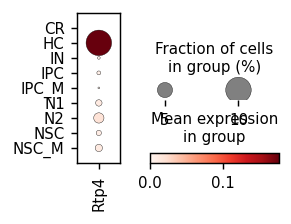

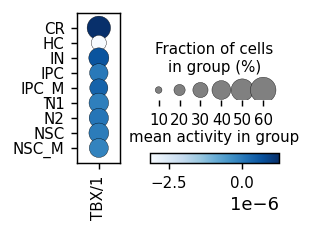

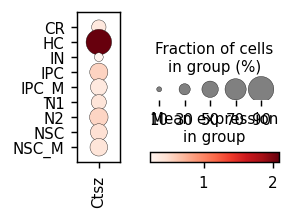

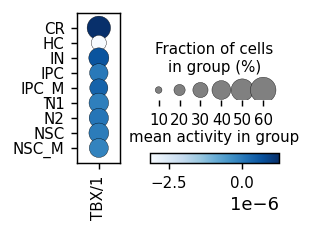

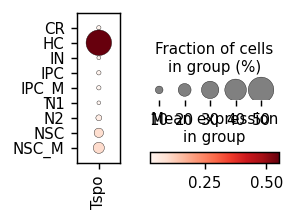

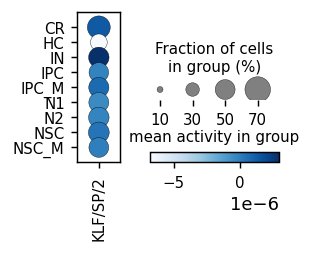

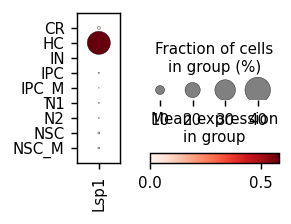

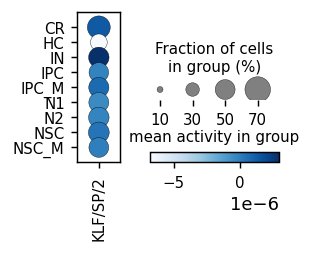

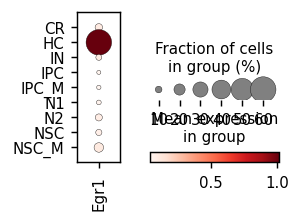

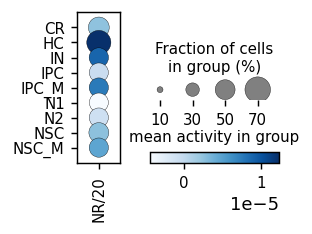

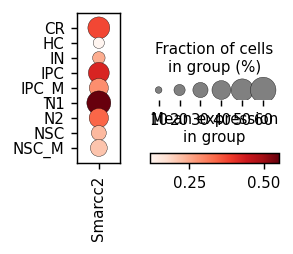

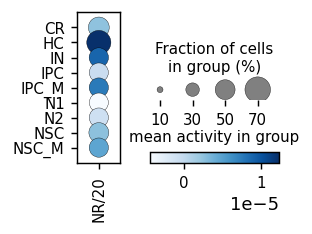

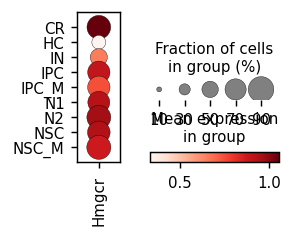

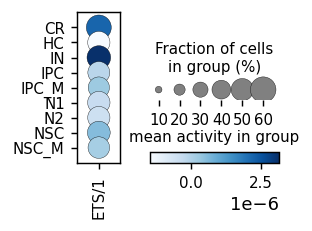

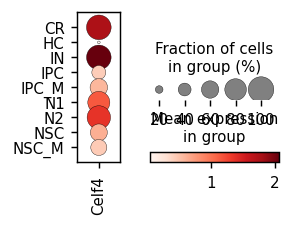

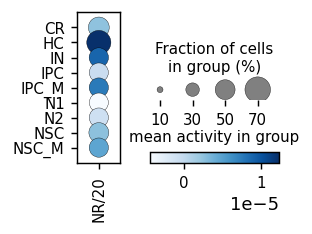

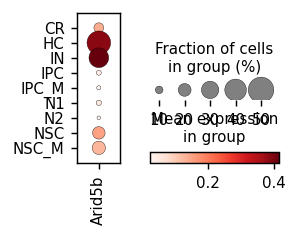

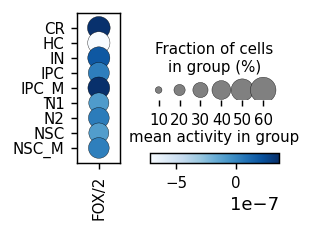

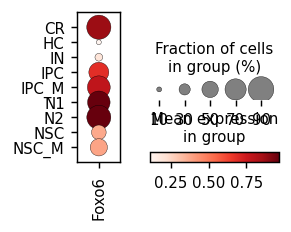

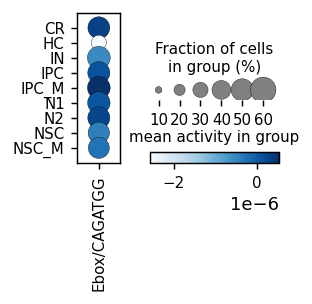

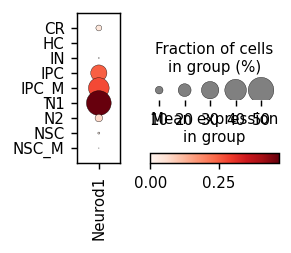

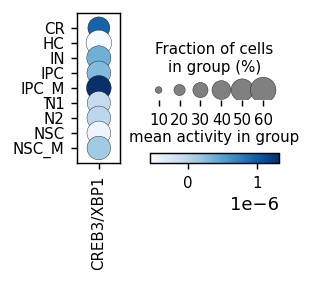

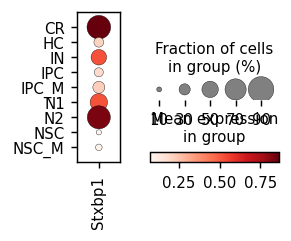

In [111]:

for ri, r in corr.sort_values('p_val').groupby('cell_type').head(3).iterrows():
    # ad_act.obs['HD/2'] = log_act['HD/2']
    sc.pl.dotplot(ad_act,
                groupby=cell_type_key,
                cmap='Blues',
                var_names=r['module_name'],
                figsize=[2, 1.5],
                colorbar_title='mean activity in group')
    sc.pl.dotplot(rna_sel,
                  groupby=cell_type_key,
                  var_names=r['gene_name'],
                  figsize=[2, 1.5])